# Welcome to the Sendy Logistics Challenge

## Group 9: JHB

Logistics in **Sub-Saharan Africa** increases the cost of manufactured goods by up to `320%`; while in **Europe**, 
it only accounts for up to `90%` of the manufacturing cost. The aim of this hackathon is to help Sendy **predict
delivery time from driver picking up the item to the time of delivery**. This will help Sendy to enhance 
customer `communication`, `reliability`, and `customer experience` in general. In addition, the solution will 
enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved
resource management and planning for order scheduling. In this assignment, we shall be applying machine 
learning regression models to make the preditions. Let us begin by loading the python modules necessary
for data handling, statistics and also for visualizations:

In [1]:
#import numpy module
import numpy as np
# import the pandas module
import pandas as pd

#importing library for stats
import scipy.stats as st

# import the seaborn module
import seaborn as sns
# import the matplotlib module
import matplotlib.pyplot as plt

## Train Dataset
### Dataset used to train prediction model
We begin by loading the training and the riders data sets: we do this so that we can merge the two tables to get a full picture of every delivery item. We continue by ensuring that all column names are in lower letter cases. Furthermore, we use the pandas info method to gather details of the 
data set: It captures column names, count of non-null entries per column and also the data type of the column. 

In [2]:
# Train Dataset
train_df = pd.read_csv('data/Train.csv')

riders = pd.read_csv("data/Riders.csv")
riders['RidersID'] = range(len(riders))
train_df = pd.merge(train_df,riders,on="Rider Id")
train_df.columns = [name.lower() for name in train_df.columns]

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   order no                                   21201 non-null  object 
 1   user id                                    21201 non-null  object 
 2   vehicle type                               21201 non-null  object 
 3   platform type                              21201 non-null  int64  
 4   personal or business                       21201 non-null  object 
 5   placement - day of month                   21201 non-null  int64  
 6   placement - weekday (mo = 1)               21201 non-null  int64  
 7   placement - time                           21201 non-null  object 
 8   confirmation - day of month                21201 non-null  int64  
 9   confirmation - weekday (mo = 1)            21201 non-null  int64  
 10  confirmation - time   

# Feature Engineering

From the output of the info method, we can already see issues with the temperature and precipitations columns: the precipitation column only has ~3%  while the temperature column has ~80% of data  as compared to the length of the dataframe. This lead to the decision to drop the precipitation column and then fill the temperature column by means of imputation. The next stop was to look at categorical data: a trick is to look at all columns of type object from the pandas info method. In this section, we changed the time to seconds: this was done to keep the data precise to the second. The following columns were dropped:
1. precipitation in millimeters : column only has ~3% of valid entries
2. arrival at destination - day of month : variable we are trying to predict
3. arrival at destination - time : variable we are trying to predict
4. arrival at destination - weekday (mo = 1) : variable we are trying to predict
5. order no : every entry is unique
6. user id : We did not think it has much effect
7. vehicle type: there was only one type of vehicle i.e Bikes



In [3]:
train_df.drop(["arrival at destination - day of month","arrival at destination - time"],axis=1,inplace=True)

In [4]:
def remove_colon(number):
    """Takes a number as a string and removes  """
    if number[-1]==':' or number[-1]=='A' or number[-1]=='P' :
        number = number[:-1]
        
    return number

def convert_dates_to_seconds(df, date,time):
    """takes in pandas dataframe and converts time stamps
    into seconds """
    date_in_seconds = []
    days_in_seconds = (df[date]-1)*3600*24
    
    for i in range(len(df)):
        hours = int(remove_colon(df[time][i][:2]))
        mins =  int(remove_colon(df[time][i][3:5]))
        seconds =  int(remove_colon(df[time][i][6:9]))
        
        if df[time][i][-2:] =='PM':
            date_in_seconds.append((hours+12)*3600+mins*60+seconds)
            
        else:
            date_in_seconds.append((hours)*3600+mins*60+seconds)
                
        
    
    return np.array(date_in_seconds)+np.array(days_in_seconds)


def correct_data_format_train(df):
    df = df.copy()
    """takes in data frame and transforms it into preferred data frame """
    
    convert_columns = {"placement - day of month":"placement - time",
                       "confirmation - day of month":"confirmation - time",
                      "pickup - day of month":"pickup - time",
                       "arrival at pickup - day of month":"arrival at pickup - time"}
    

    drop_columns = ["precipitation in millimeters",
                    "arrival at destination - day of month",
                    "arrival at destination - time",
                    "arrival at destination - weekday (mo = 1)",
                    "order no","user id","vehicle type","order no","rider id"]
    for column_name in df.columns:
        if column_name in convert_columns:
            df[convert_columns[column_name]] = convert_dates_to_seconds(df,date=column_name ,time =convert_columns[column_name])
        elif column_name in drop_columns:
            df.drop(column_name,axis=1,inplace=True)
            
    #Fillingna and dummy variable
    df['temperature'].fillna(df['temperature'].mean(),inplace=True)
    #df["personal or business"] = pd.get_dummies(df["personal or business"],drop_first=True)
    #pd.get_dummies(train["Rider Id"],drop_first=True)
    
    return df

In [5]:
train_df = correct_data_format_train(train_df)

In [6]:
train_df.head()

,platform type,personal or business,placement - day of month,placement - weekday (mo = 1),placement - time,confirmation - day of month,confirmation - weekday (mo = 1),confirmation - time,arrival at pickup - day of month,arrival at pickup - weekday (mo = 1),...,pickup lat,pickup long,destination lat,destination long,time from pickup to arrival,no_of_orders,age,average_rating,no_of_ratings,ridersid
0,3,Business,9,5,723906,9,5,723600,9,5,...,-1.317755,36.830370,-1.300406,36.829741,745,1637,1309,13.8,549,27
1,3,Personal,18,5,1522867,18,5,1522860,18,5,...,-1.326774,36.787807,-1.356237,36.904295,2886,1637,1309,13.8,549,27
2,3,Business,31,5,2681501,31,5,2638929,31,5,...,-1.255189,36.782203,-1.273412,36.818206,2615,1637,1309,13.8,549,27
3,3,Personal,2,2,111720,2,2,111729,2,2,...,-1.290315,36.757377,-1.223520,36.802061,2986,1637,1309,13.8,549,27
4,2,Personal,22,2,1852858,22,2,1852944,22,2,...,-1.273524,36.799220,-1.300431,36.752427,1602,1637,1309,13.8,549,27


**The head of the dataframe reveals that we have done our preprocessing excellently. We have all the columns in numerical format except the column "personal or business" since we want to use that information for our visualizations in the next step.  We make comments on the visuals right after they appear.**

# Visualizations

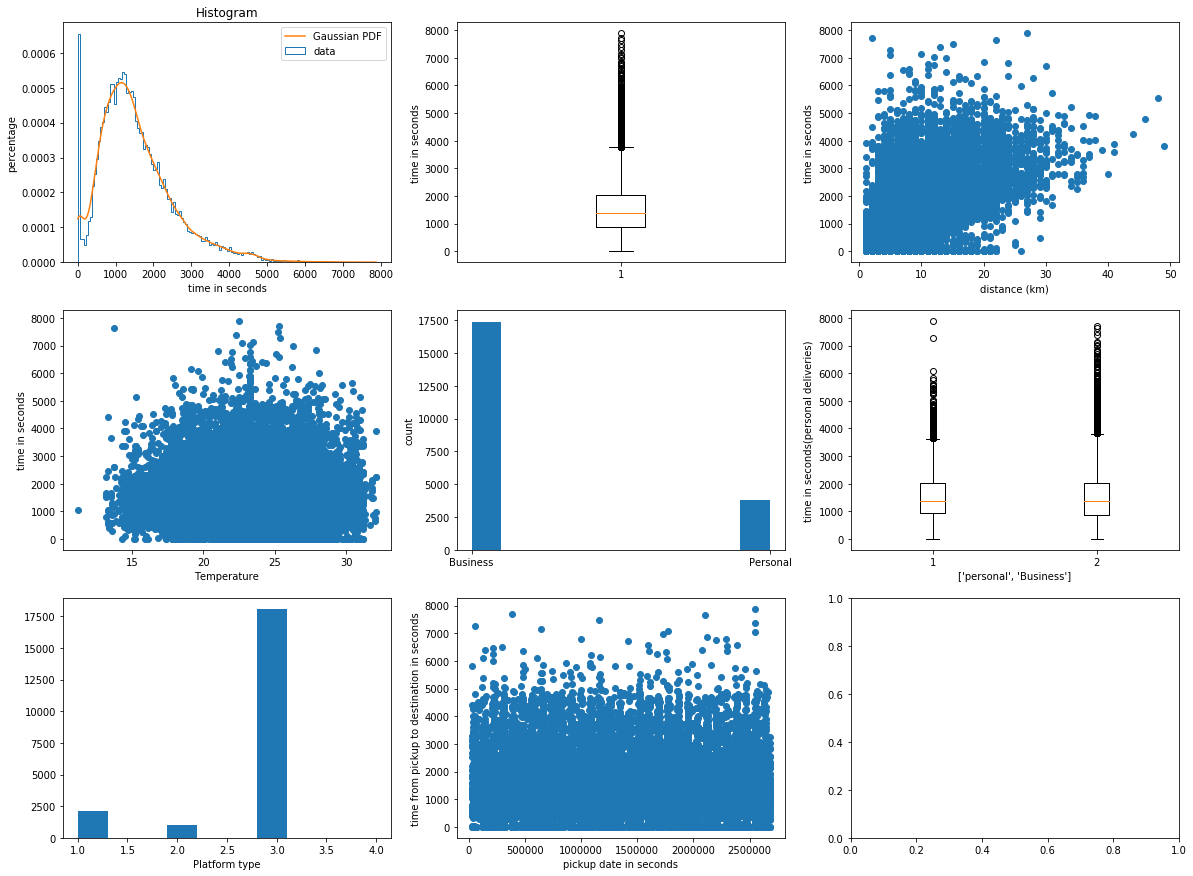

In [7]:
fig, ((ax1, ax2, ax3), (ax4, ax5 ,ax6),(ax7, ax8,ax9)) = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False,figsize = (20,15))



ax1.hist(train_df["time from pickup to arrival"], 150, histtype = 'step',density = True, label = "data");
kde_xs = np.linspace(0, train_df["time from pickup to arrival"].max(), 301)
kde = st.gaussian_kde(train_df["time from pickup to arrival"])
ax1.plot(kde_xs, kde.pdf(kde_xs), label="Gaussian PDF")
ax1.legend(loc="upper right")
ax1.set_xlabel("time in seconds")
ax1.set_ylabel("percentage");
ax1.set_title("Histogram");


ax2.boxplot(x=train_df["time from pickup to arrival"])
ax2.set_ylabel("time in seconds");

ax3.scatter(train_df["distance (km)"],train_df["time from pickup to arrival"])
ax3.set_xlabel("distance (km)")
ax3.set_ylabel("time in seconds")

ax4.scatter(train_df["temperature"],train_df["time from pickup to arrival"])
ax4.set_xlabel("Temperature")
ax4.set_ylabel("time in seconds")

ax5.hist(train_df["personal or business"])
ax5.set_ylabel("count")

#ax6.hist(train_df[train_df["personal or business"]=="Business"]["time from pickup to arrival"])
#ax6.set_ylabel("count")
ax6.boxplot([train_df[train_df["personal or business"]=="Personal"]["time from pickup to arrival"],
             train_df[train_df["personal or business"]=="Business"]["time from pickup to arrival"]])
ax6.set_ylabel("time in seconds(personal deliveries)");
ax6.set_xlabel(["personal","Business"])


#ax7.hist(train["Rider Id"], bins=960)
#ax7.set_ylabel("count")
#ax7.boxplot(x=train_df[train_df["personal or business"]=="Business"]["time from pickup to arrival"])
#ax7.set_ylabel("time in seconds(Business deliveries)");

ax8.scatter(train_df["pickup - time"],train_df["time from pickup to arrival"])
ax8.set_xlabel("pickup date in seconds")
ax8.set_ylabel("time from pickup to destination in seconds")

ax7.hist(train_df["platform type"], bins = 10)
ax7.set_xlabel("Platform type")


#saving images
fig.savefig('images/full_figure.png',transparent = True)
extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('images/distribution', bbox_inches=extent)


**Take away points from the above visuals:**
*  `Temperature` does not seem to play a role in time taken to complete deliveries
* `Time taken` for deliveries follows a normal distribution: hence we can use corresponding mathematics to improve our predictions
* A lot of deliveries were for `businesses` rather than individuals.
* Looking at the box plot tell us that there were `deliveries` made in `10 seconds and less`: this is actually concerning
* There seem to be a positive linear relation between `distance` and `time taken`


In [8]:
train_df["time from pickup to arrival"].max()

7883

In [9]:
train_df["personal or business"] = pd.get_dummies(train_df["personal or business"],drop_first=True)

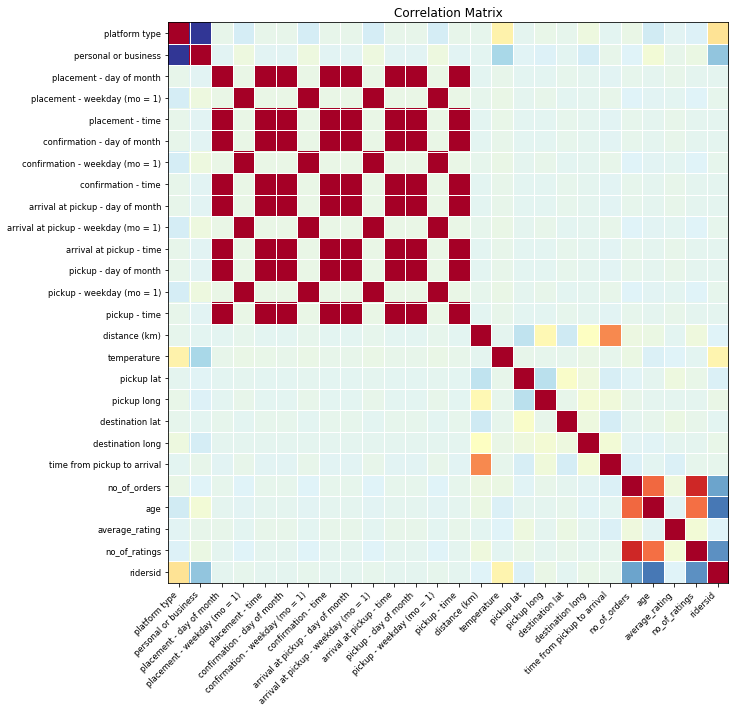

In [10]:
from statsmodels.graphics.correlation import plot_corr

fig = plt.figure(figsize=(20,10));
ax = fig.add_subplot(111);
plot_corr(train_df.corr(), xnames = train_df.corr().columns, ax = ax)
fig.savefig('images/correlation.jpg',optimize=True,transparent=True,bbox_inches='tight')

The `correlation heat map` tell us how `different` features `correlate` with each other. The dark `meroon` says a strong correlation while a dark `blue` suggest there is no correlation between those features whatsoever. The following insights can be captured from the map:

* There is a strong self correlation of features (as expected and shown by the diagonal from top left to bottom right corners)
* There is a mild correlation between `time taken` and `distance`

In [11]:
train_df[train_df["time from pickup to arrival"] <5]

,platform type,personal or business,placement - day of month,placement - weekday (mo = 1),placement - time,confirmation - day of month,confirmation - weekday (mo = 1),confirmation - time,arrival at pickup - day of month,arrival at pickup - weekday (mo = 1),...,pickup lat,pickup long,destination lat,destination long,time from pickup to arrival,no_of_orders,age,average_rating,no_of_ratings,ridersid
30,3,0,21,2,1782540,21,2,1785602,21,2,...,-1.324488,36.897792,-1.301446,36.766138,2,396,339,13.6,69,739
187,3,0,7,5,572585,7,5,572700,7,5,...,-1.286745,36.825902,-1.300921,36.828195,3,886,283,14.5,113,806
197,3,0,3,1,261609,3,1,261786,3,1,...,-1.322800,36.830644,-1.263818,36.793006,3,886,283,14.5,113,806
218,3,0,6,4,489784,6,4,489662,6,4,...,-1.272639,36.794723,-1.235348,36.760016,4,886,283,14.5,113,806
225,3,0,7,5,547201,7,5,547262,7,5,...,-1.319613,36.711055,-1.286745,36.825902,3,886,283,14.5,113,806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20818,3,0,30,2,2559784,30,2,2559842,30,2,...,-1.258184,36.801706,-1.262215,36.808739,2,2986,2846,13.9,568,534
20836,3,0,2,2,140888,2,2,140880,2,2,...,-1.255189,36.782203,-1.256659,36.792968,2,4380,2363,14.3,972,434
20934,3,0,7,3,558248,7,3,558284,7,3,...,-1.270212,36.821088,-1.263987,36.798891,3,1225,2253,13.2,301,154
20961,3,0,7,3,607955,7,3,607968,7,3,...,-1.290894,36.822971,-1.288780,36.816831,4,4923,1651,14.4,2018,582


## Test Dataset
### Dataset used to test prediction accuracy of model

We transformed the training set, `it is also required to transform the testing data aswell`. This is a requirement for machine learning. Finally we ensure that the training set have the same format: ensure that the two sets have the same features with the same data format and feature names.

In [12]:
# Test Dataset
test_df = pd.read_csv('data/Test.csv')
#test = correct_data_format(test)
test_df = pd.merge(test_df,riders,on="Rider Id")
test_df.columns = [name.lower() for name in test_df.columns]
test_df.head()

,order no,user id,vehicle type,platform type,personal or business,placement - day of month,placement - weekday (mo = 1),placement - time,confirmation - day of month,confirmation - weekday (mo = 1),...,pickup lat,pickup long,destination lat,destination long,rider id,no_of_orders,age,average_rating,no_of_ratings,ridersid
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171,183
1,Order_No_2699,User_Id_592,Bike,1,Personal,26,2,2:43:21 PM,26,2,...,-1.312745,36.875715,-1.288435,36.760677,Rider_Id_192,439,1511,13.3,171,183
2,Order_No_21486,User_Id_478,Bike,3,Business,29,5,11:55:05 AM,29,5,...,-1.255189,36.782203,-1.293393,36.790237,Rider_Id_192,439,1511,13.3,171,183
3,Order_No_19336,User_Id_2801,Bike,3,Business,2,1,9:23:21 AM,2,1,...,-1.310451,36.868724,-1.259542,36.787118,Rider_Id_192,439,1511,13.3,171,183
4,Order_No_20374,User_Id_3465,Bike,3,Business,14,4,12:55:59 PM,14,4,...,-1.333275,36.870815,-1.255189,36.782203,Rider_Id_192,439,1511,13.3,171,183


In [13]:
def correct_data_test(df):
    df = df.copy()
    """takes in data frame and transforms it into preferred data frame """
    
    #convert dates
    
    convert_columns = {"placement - day of month":"placement - time","confirmation - day of month":"confirmation - time",
                      "pickup - day of month":"pickup - time","arrival at pickup - day of month":"arrival at pickup - time"}
    
    #df["Placement - Time"] = convert_dates_to_seconds(df,date= "Placement - Day of Month",time ="Placement - Time")
    #df["Confirmation - Time"] = convert_dates_to_seconds(df,date= "Confirmation - Day of Month",time ="Confirmation - Time")
    #df["Pickup - Time"] = convert_dates_to_seconds(df,date= "Pickup - Day of Month",time ="Pickup - Time")
    #df["Arrival at Pickup - Time"] = convert_dates_to_seconds(df,date= "Arrival at Pickup - Day of Month",time ="Arrival at Pickup - Time")
    #drop columns
    drop_columns = ["placement - day of month","confirmation - day of month", "precipitation in millimeters",
                    "pickup - day of month","arrival at destination - day of month",
            "arrival at destination - time","user id","vehicle type","rider id"]
    for column_name in df.columns:
        if column_name in convert_columns:
            df[convert_columns[column_name]] = convert_dates_to_seconds(df,date=column_name ,time =convert_columns[column_name])
        elif column_name in drop_columns:
            df.drop(column_name,axis=1,inplace=True)
            
    #Fillingna and dummy variable
    df['temperature'].fillna(df['temperature'].mean(),inplace=True)
    df["personal or business"] = pd.get_dummies(df["personal or business"],drop_first=True)
    #pd.get_dummies(train["Rider Id"],drop_first=True)
    
    return df

In [14]:
test_df = correct_data_test(test_df)
submission = pd.DataFrame({"Order_No":test_df.pop("order no")})
test_df.head()

,platform type,personal or business,placement - day of month,placement - weekday (mo = 1),placement - time,confirmation - day of month,confirmation - weekday (mo = 1),confirmation - time,arrival at pickup - day of month,arrival at pickup - weekday (mo = 1),...,temperature,pickup lat,pickup long,destination lat,destination long,no_of_orders,age,average_rating,no_of_ratings,ridersid
0,3,0,27,3,2304240,27,3,2304249,27,3,...,23.24612,-1.333275,36.870815,-1.305249,36.822390,439,1511,13.3,171,183
1,1,1,26,2,2210581,26,2,2210826,26,2,...,23.24612,-1.312745,36.875715,-1.288435,36.760677,439,1511,13.3,171,183
2,3,0,29,5,2462105,29,5,2462292,29,5,...,19.70000,-1.255189,36.782203,-1.293393,36.790237,439,1511,13.3,171,183
3,3,0,2,1,118981,2,1,118984,2,1,...,16.40000,-1.310451,36.868724,-1.259542,36.787118,439,1511,13.3,171,183
4,3,0,14,4,1212959,14,4,1170124,14,4,...,21.30000,-1.333275,36.870815,-1.255189,36.782203,439,1511,13.3,171,183


In [15]:
train_df.drop("time from pickup to arrival",axis = 1).columns == test_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

## Fit regression models to data

we are now ready to fit the regression models to the data. We will fit three models to the data: 
* Multiple Linear Regression
* Polynomial Regression
* Decision tree
* Random forest

we fit these models to train data and then compare them using validation set which we obtain from 
`train_test_split` method which we obtain from the `sklearn model selection` library. We end this
section by looking at the statistical metrics to see which method works best for us

### Multiple linear regression MLR

Multiple linear regression is an ensemble of simple linear regressions. Simple linear regression takes the form $$y=mx + c$$ 
where $y$ is the dependent variable, $x$ is the independent, $m$ is the slope and $c$ is the intercept. This is when we are considering 
only a single feature. When we have, and are considering $n$ features, the model becomes $$y=m_1x_1+m_2x_2+\ldots+m_nx_n + c$$ where $x_1,\ldots,x_n$
represent the features in the data, and $m_1 \ldots m_n$ 


In [16]:
#separate independent and dependant variables

x_train = train_df.drop("time from pickup to arrival",axis = 1).values

y_train = train_df.pop("time from pickup to arrival").values

In [144]:
#from sklearn.model_selection import train_test_split
#x_train,x_validation,y_train,y_validation = train_test_split(x_train,y_train,test_size=0.1)

In [153]:
#fit the multiple linear regression to the training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [154]:
#make the prediction
y_pred = regressor.predict(x_validation)

In [155]:
from sklearn.metrics import mean_squared_error, r2_score


mean_square_MLR_vali = mean_squared_error(y_validation,y_pred)**0.5
mean_square_MLR_train = mean_squared_error(y_train,regressor.predict(x_train))**0.5


r2_MLR_train = r2_score(y_train,regressor.predict(x_train))
r2_MLR_valid = r2_score(y_validation,y_pred)

In [156]:
mean_square_MLR_train
#r2_MLR_valid

792.0911675447462

In [157]:
#submission["Time from Pickup to Arrival"] = y_pred.round(0)
#submission.to_csv('Submissions/submission_multilinear.csv', index=False)

## Polynomial regression model

In [158]:
#build the polynomial regression model
from sklearn.preprocessing import PolynomialFeatures
polynomial_regressor = PolynomialFeatures(degree = 3)
x_poly = polynomial_regressor.fit_transform(x_train)
linear_regressor2 = LinearRegression()
linear_regressor2.fit(x_poly,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [159]:
#make the prediction
y_pred = linear_regressor2.predict(polynomial_regressor.fit_transform(x_validation))



In [160]:
mean_square_pol_vali = mean_squared_error(y_validation,y_pred)**0.5
mean_square_pol_train = mean_squared_error(y_train,linear_regressor2.predict(polynomial_regressor.fit_transform(x_train)))**0.5


r2_pol_train = r2_score(y_train,linear_regressor2.predict(polynomial_regressor.fit_transform(x_train)))
r2_pol_valid = r2_score(y_validation,y_pred)

In [161]:
#submission["Time from Pickup to Arrival"] = y_pred.round(0)
#submission.to_csv('Submissions/submission_polynomial.csv', index=False)

## Decision Tree Regression


Decision tree builds regression models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. The nodes are developed such that 
we have binary decisions at each node.

In [163]:
#fit the decision tree regressor
from sklearn.tree import DecisionTreeRegressor 
DT_regressor = DecisionTreeRegressor()
DT_regressor.fit(x_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [164]:
y_pred = DT_regressor.predict(x_validation)

In [165]:
mean_square_dt_vali = mean_squared_error(y_validation,y_pred)**0.5
mean_square_dt_train = mean_squared_error(y_train,DT_regressor.predict(x_train))**0.5


r2_dt_train = r2_score(y_train,DT_regressor.predict(x_train))
r2_dt_valid = r2_score(y_validation,y_pred)

In [166]:
#submission["Time from Pickup to Arrival"] = y_pred.round(0)
#submission.to_csv('Submissions/submission_DT.csv', index=False)

# Random forest regression: RF

The main idea behind random forest is to combine predictions made by many decision trees into a single model.
A prediction made by a single decision tree may not be accurate, however, a prediction by an ensemble of 
decision trees tends to the true value on average.



In [20]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators=350, max_depth=15)
RF.fit(x_train,y_train)



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=350, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [21]:
y_pred =RF.predict(test_df)

submission["Time from Pickup to Arrival"] = y_pred.round(0)
submission.to_csv('Submissions/submission_RF.csv', index=False)

In [173]:
mean_square_RF_vali = mean_squared_error(y_validation,y_pred)**0.5
mean_square_RF_train = mean_squared_error(y_train,RF.predict(x_train))**0.5


r2_RF_train = r2_score(y_train,RF.predict(x_train))
r2_RF_valid = r2_score(y_validation,y_pred)

## Model assessment
We will test all our method now. We need to look at the errors and also talk about underfitting and/or overfitting
choose a model which is best suited for our data.


In [174]:
Error_df = pd.DataFrame({"Model":["MLR","pol","DT","RF"],
                         "MSE train":[mean_square_MLR_train,mean_square_pol_train,mean_square_dt_train,mean_square_RF_train],
                        "MSE test":[mean_square_MLR_vali,mean_square_pol_vali,mean_square_dt_vali,mean_square_RF_vali ],
                        "R^2 train":[r2_MLR_train,r2_pol_train,r2_dt_train,r2_RF_train ],
                        "R^2 test":[r2_MLR_valid,r2_pol_valid,r2_dt_valid,r2_RF_valid]})
Error_df.round(3)

,Model,MSE train,MSE test,R^2 train,R^2 test
0,MLR,792.091,771.641,0.340,0.368
1,pol,736.596,1084.867,0.429,-0.249
2,DT,0.000,1105.924,1.000,-0.298
3,RF,612.343,743.140,0.605,0.414


* The worst perfoming model was the decision tree: The mean square error indicate `over-fitting`
* The second worst was the polynomial model: Mean square also indicating `overfitting`
* MLR and RF are `balanced`: MSE difference lower than 200(we decided on that)
* RF forest have a better $R^2$ value

## Conclusions

We ended up choosing **Random Forest** because it was balanced and fitted our data set the best of all the models that we looked at.

The model can be improved if:
* We define realistic delivery times: recall deliveries of less than 10 s.
* Do more feature engineering: create columns that specify if its weekend or not...
* Add standard deviation of the time taken to the predicted time
* supply more data: we only had one month data